In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow
!pip install pickle
!pip install tsfel
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
import shap
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output
import tsfel


In [4]:
def _shap_div_no_nan(op, grad):
    x, y = op.inputs
    not_zero = tf.greater(tf.abs(y), 1e-12)
    not_inf = tf.logical_not(tf.logical_or(tf.is_inf(y), tf.is_inf(grad)))
    valid = tf.logical_and(not_zero, not_inf)
    return tf.where(valid, grad / y, tf.zeros_like(grad))

# Register the gradient function with Keras
K.__dict__["gradients"] = _shap_div_no_nan

NameError: name 'K' is not defined

In [267]:
! pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astor                         0.8.1
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi

In [ ]:
batch1 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [ ]:
numBat1 = len(batch1.keys())
numBat1

In [ ]:
batch2 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch3.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [ ]:

numBat2 = len(batch2.keys())
numBat2
batch3 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch2.pkl','rb'))

numBat3 = len(batch3.keys())
numBat3
numBat = numBat1 + numBat2 + numBat3
numBat

In [ ]:
bat_dict = {**batch1, **batch2, **batch3}

In [ ]:
for i in bat_dict.keys():
  plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [ ]:
bat_dict_keys = bat_dict.keys()

In [ ]:
RUL = []

for i in bat_dict_keys:
  
    cell = bat_dict[i]
    #len_summary_cycle = len(cell['summary']['cycle'])
    cycle_life = int(cell['summary']['cycle'][-1])
    for j in range(1,cycle_life):
        RUL.append(cycle_life-j)

In [ ]:
len(RUL)

In [ ]:
def linear_interpolation(x, y, start, end, x_lin):
    x = x[start:end]
    y = y[start:end]
    f = interp1d(x,y)
    datalin = f(x_lin)
    datalin = smooth_curve(datalin)
    
    return(datalin)

In [ ]:
def smooth_curve(points, factor=0.6):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
cycle_vector_features = (['Idlin', 
                          'Qdlin', 
                          'Tdlin', 
                          'dQdV'])

# Liste des features scalaires
cycle_scalar_features = (['IR', 
                          'Tavg', 
                          'Tmin', 
                          'Tmax', 
                          'QC', 
                          'QD', 
                          'SOH', 
                          'chargetime'])

# Définition des différentes matrices qui vont contenir les données d'entrainement

# matrice vectorielle 
cycle_vector_dataset_arr = np.zeros((len(RUL), len(cycle_vector_features), 200)) 
# matrice scalaire
cycle_scalar_dataset_arr = np.zeros((len(RUL), len(cycle_scalar_features))) 
# matrice commune vectorielle/scalaire
cycle_dataset_arr = (np.empty((len(RUL), 
                               len(cycle_vector_features)+len(cycle_scalar_features), 
                               200))) 
cycle_dataset_arr[:] = np.NaN


# Définition des différents dictionnaires qui vont contenir les données d'entrainement
cycle_vector_dataset_dict = {} #dictionnaire vectoriel
cycle_scalar_dataset_dict = {} #dictionnaire scalaire
global_dataset = {} # dictionnaire commun vectoriel/scalaire

s=0 # la variable s compte le nombre d'échantillons dans le dataset
for i in bat_dict_keys : # On parcourt toutes les cellules du dataset brut
    clear_output(wait=True)
    cell = bat_dict[i]   
    print('cell:', i) #affichage de la cellule de batterie en cours 
    cycle_life = len(cell['summary']['cycle'])
    
    for j in range(1,cycle_life): # on parcourt tous les cycles de la cellule 
        
        # récupération des données vectorielles 
        # on ne récupère que les données de décharge
        
        start_discharge = np.where(cell['cycles'][str(j)]['I'] < -0.05) # Début de la décharge
        start_discharge = start_discharge[0][0]
        
        end_discharge = np.where(cell['cycles'][str(j)]['I'] < -3.9) # Fin de la décharge
        end_discharge = end_discharge[0][-1]
        
        Vmin = min(cell['cycles'][str(j)]['V'][start_discharge:end_discharge]) 
        Vmax = max(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        
        x_discharge = np.linspace(Vmax,Vmin,200) # Vecteur de référence à partir duquel 
                                                 # l'interpolation linéaire est réalisée
            
        # interpolation linéaire du courant, capacité de décharge et température   
        Idlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['I'], \
                                     start_discharge, end_discharge, x_discharge)
        Qdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['Qd'], \
                                     start_discharge, end_discharge, x_discharge)
        Tdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['T'], \
                                     start_discharge, end_discharge, x_discharge)
        
        # interpolation linéaire de dQdV 
        g = interp1d(np.linspace(Vmax,Vmin,1000), cell['cycles'][str(j)]['dQdV'])
        dQdV = g(x_discharge)
        
        # Les vecteurs sont regroupés dans la matrice vectorielle
        cycle_vector_dataset_arr[s+j-1][0] = Idlin
        cycle_vector_dataset_arr[s+j-1][1] = Qdlin
        cycle_vector_dataset_arr[s+j-1][2] = Tdlin
        cycle_vector_dataset_arr[s+j-1][3] = dQdV
        
        # les vecteurs sont également regroupés dans la matrice globale
        cycle_dataset_arr[s+j-1][0] = Idlin
        cycle_dataset_arr[s+j-1][1] = Qdlin
        cycle_dataset_arr[s+j-1][2] = Tdlin
        cycle_dataset_arr[s+j-1][3] = dQdV
        
        # Un dictionnaire "échantillon" contenant uniquement 
        # les vecteurs de ce cycle est créé
        vector_sample_dict = ({'Idlin' : Idlin, 
                               'Qdlin' : Qdlin, 
                               'Tdlin' : Tdlin,
                               'dQdV'  : dQdV  }
                             )
        
        # Récupération des données scalaires
        IR = cell['summary']['IR'][j]
        Tavg = cell['summary']['Tavg'][j]
        Tmin = cell['summary']['Tmin'][j]
        Tmax = cell['summary']['Tmax'][j]
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        chargetime = cell['summary']['chargetime'][j]
        SOH = (QD/cell['summary']['QD'][1])*100 
        
        # Les scalaires sont regroupés dans la matrice scalaire
        cycle_scalar_dataset_arr[s+j-1][0] = IR
        cycle_scalar_dataset_arr[s+j-1][1] = Tavg
        cycle_scalar_dataset_arr[s+j-1][2] = Tmin
        cycle_scalar_dataset_arr[s+j-1][3] = Tmax
        cycle_scalar_dataset_arr[s+j-1][4] = QC
        cycle_scalar_dataset_arr[s+j-1][5] = QD
        cycle_scalar_dataset_arr[s+j-1][6] = chargetime
        cycle_scalar_dataset_arr[s+j-1][7] = SOH
        
        # Les scalaires sont également ajoutés 
        # à la suite des vecteurs dans la matrice globale
        cycle_dataset_arr[s+j-1][4][0] = IR
        cycle_dataset_arr[s+j-1][5][0] = Tavg
        cycle_dataset_arr[s+j-1][6][0] = Tmin
        cycle_dataset_arr[s+j-1][7][0] = Tmax
        cycle_dataset_arr[s+j-1][8][0] = QC
        cycle_dataset_arr[s+j-1][9][0] = QD
        cycle_dataset_arr[s+j-1][10][0] = chargetime
        cycle_dataset_arr[s+j-1][11][0] = SOH
                
        # Un dictionnaire "échantillon" contenant uniquement 
        # les scalaires de ce cycle est créé
        scalar_sample_dict = ({'IR': IR , 
                               'Tavg': Tavg , 
                               'Tmin' : Tmin , 
                               'Tmax' : Tmax , 
                               'QC': QC, 
                               'QD':QD, 
                               'chargetime':chargetime, 
                               'SOH':SOH}
                             )
        
        # Les deux dictionnaires échantillons (vectoriel et scalaire) sont  
        # regroupés dans un dictionnaire échantillon global contenant 
        # à la fois les vecteurs et les scalaires de ce cycle
        global_sample_dict = {**vector_sample_dict, **scalar_sample_dict}
    
        # Attribution d'un intitulé à chaque échantillon
        dict_key = "{}_cycle_{}".format(i,j) 
        
        # Le dictionnaire échantillon vectoriel est ajouté au dictionnaire vectoriel
        # contenant les vecteurs de tous les cycles
        cycle_scalar_dataset_dict[dict_key] = scalar_sample_dict
        
        # Le dictionnaire échantillon scalaire est ajouté au dictionnaire scalaire
        # contenant les scalaires de tous les cycles
        cycle_vector_dataset_dict[dict_key] = vector_sample_dict
        
        # Le dictionnaire échantillon global est ajouté au dictionnaire global 
        # contenant les vecteurs et les scalaires de chaque cycle
        global_dataset[dict_key] = global_sample_dict
        
    s+=j # s représente le numéro de l'échantillon créé 
print('all cycles from batches 1, 2 and 3 were browsed')

In [245]:
cycle_vector_dataset_df = pd.DataFrame(cycle_vector_dataset_dict)

# Création d'un dataframe scalaire
cycle_scalar_dataset_df = pd.DataFrame(cycle_scalar_dataset_dict)

#Création d'un dataframe global
cycle_dataset_df = pd.DataFrame(global_dataset)

In [246]:
cycle_dataset_df

,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,b1c0_cycle_10,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
Idlin,"[-0.560043509090909, -0.6968178407725167, -0.9...","[-0.5200932272727272, -0.6591509167191169, -0....","[-0.5199423727272726, -0.6578318908908884, -0....","[-0.5999712545454545, -0.7368716804921043, -0....","[-0.5998438090909091, -0.7365053004657165, -0....","[-0.6000995636363636, -0.739821696962288, -0.9...","[-0.4799444, -0.624206668715477, -0.8462405869...","[-0.5996556727272727, -0.7388988143431376, -0....","[-0.5199475727272728, -0.6596524905155831, -0....","[-0.5598857181818182, -0.6992990799571797, -0....",...,"[-0.4394722, -0.5600132847924018, -0.747594117...","[-0.4399039545454545, -0.560833018440097, -0.7...","[-0.44002272727272723, -0.5611238890610376, -0...","[-0.4000932545454545, -0.522952596107014, -0.7...","[-0.3996883727272727, -0.522714353169983, -0.7...","[-0.43852199090909083, -0.5572443836420431, -0...","[-0.43979210909090904, -0.5521015207414934, -0...","[-0.40040622727272723, -0.5202735743349837, -0...","[-0.40016608181818175, -0.5191046374039734, -0...","[-0.40032993636363634, -0.5232802077076555, -0..."
Qdlin,"[9.0033354e-06, 9.0033354e-06, 9.0033354e-06, ...","[4.4997469e-06, 4.4997469e-06, 4.4997469e-06, ...","[5.4048696e-06, 5.4048696e-06, 8.5953235332171...","[7.4323725e-06, 7.4323725e-06, 7.4323725e-06, ...","[7.7532759e-06, 7.7532759e-06, 7.7532759e-06, ...","[4.1716985e-06, 4.1716985e-06, 4.1716985e-06, ...","[6.8169729e-06, 6.816972899999999e-06, 6.81697...","[6.1982837e-06, 6.1982837e-06, 6.1982837e-06, ...","[6.7026822e-06, 6.7026822e-06, 6.7026822e-06, ...","[8.3895693e-06, 8.3895693e-06, 8.3895693e-06, ...",...,"[4.2034671e-06, 4.2034671e-06, 1.0388625852373...","[4.4097774e-06, 4.4097774e-06, 4.4097774e-06, ...","[4.4317703e-06, 4.4317703e-06, 4.4317703e-06, ...","[3.2687278e-06, 3.2687278e-06, 3.2687278e-06, ...","[3.6265888e-06, 3.6265888e-06, 3.6265888e-06, ...","[4.2054021e-06, 4.2054021e-06, 4.2054021e-06, ...","[4.2301972e-06, 4.2301972e-06, 4.2301972e-06, ...","[3.676628e-06, 3.676628e-06, 9.037884410532407...","[3.6277388e-06, 3.6277388e-06, 3.6277388e-06, ...","[3.4956697e-06, 3.4956697e-06, 3.4956697e-06, ..."
Tdlin,"[30.820534457644424, 30.819985683275526, 30.81...","[30.852327120486237, 30.85247012513102, 30.852...","[30.832358788433, 30.832283175016975, 30.83216...","[30.830612178178495, 30.830403755313593, 30.83...","[30.71032588378695, 30.710494819446023, 30.710...","[30.74225472322275, 30.74238995389081, 30.7426...","[30.773305896811685, 30.77354525152012, 30.773...","[30.777844409037773, 30.777785740594624, 30.77...","[30.90306218005518, 30.903031343368127, 30.902...","[30.995105817599928, 30.995122652272094, 30.99...",...,"[29.878868, 29.883811950126177, 29.88842157007...","[30.035067, 30.035067000000005, 30.03506700000...","[29.984766, 29.984766, 29.984766, 29.984766, 2...","[29.948359, 29.948359, 29.948359, 29.948359, 2...","[29.859871, 29.859871, 29.859871, 29.859871, 2...","[29.94058, 29.940580000000004, 29.940580000000...","[29.941271, 29.941271, 29.941271, 29.941271, 2...","[29.837681, 29.837681000000003, 29.83768100000...","[29.817024, 29.817023999999996, 29.81702399999...","[29.84683, 29.84683, 29.84683, 29.84683, 29.84..."
dQdV,"[0.0, -0.0038980357786781374, -0.0276160877263...","[0.0, 0.0, 0.0, -0.0012117839117345391, -0.030...","[-0.003899322558070411, -0.0038993225580704113...","[0.0, -0.005296338862016056, -0.03275976867477...","[0.0, 0.0, 0.0, -4.487744349151491e-05, -0.019...","[0.0, -0.0024907694423430427, -0.0276330917618...","[-0.01568066679124452, -0.01568066679124452, -...","[-0.02035724463210379, -0.02035724463210379, -...","[-0.012252776983516575, -0.012252776983516577,...","[0.0, 0.0, -0.0007758510420292511, -0.02299630...",...,"[-0.0029026259887782453,

In [247]:
df=cycle_dataset_df

In [248]:
temperatures = []
currents = []
voltages = []
capacity = 2.5 # Ah
R0 = 0.02 # ohm
v1 = 3.8 # V (assumed)


# Loop through each cycle in the dataset
for cycle in df:
    
    # Extract the data for the current cycle
    X = df[cycle]
    

   # Calculate current array
    Ir = np.divide(X["Idlin"],1000) 

   # Calculate voltage array

    v = v1 - Ir * R0 - np.divide(X["Qdlin"],capacity)

   # Calculate temperature array
    T = (Tmax + Tmin) / 2
    
    # Append the estimates to the corresponding list
    temperatures.append(np.average(T))
    currents.append(np.average(np.abs(Ir)))
    voltages.append(np.average(np.abs(v)))

In [249]:
df=pd.DataFrame({"T":temperatures,"C":currents,"V":voltages,"SOH":df.T["SOH"]})

In [250]:
df=df.reset_index()


In [251]:
df=df.drop(["Cycle_Index"],axis=1)
df[0:2]


KeyError: "['Cycle_Index'] not found in axis"

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
   X=[]
   y=[]
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop(["SOH"],axis=1))
       y.append(seq_y["SOH"])
   return X, y

In [ ]:
train_size=int(0.6*len(df))
train_data=df[0:train_size]
test_data=df[train_size:len(df)]

In [ ]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
X_train,Y_train=split_sequence(train_data,10,10)
X_test,Y_test=split_sequence(test_data,10,10)

In [252]:
Y_train[0]

10    100.293858
11    100.291385
12    100.283722
13    100.295188
14    100.298823
15    100.312959
16    100.321288
17     100.30999
18    100.316154
19    100.322496
Name: SOH, dtype: object

In [253]:
size1=len(X_train)
size2=len(X_test)
X1=np.zeros((size1,10,3))
Y1=np.zeros((size1,10))
for i in range(size1):
   X1[i]=X_train[i]
   Y1[i]=Y_train[i]
X2=np.zeros((size2,10,3))
Y2=np.zeros((size2,10))
for i in range(size2):
   X2[i]=X_test[i]
   Y2[i]=Y_test[i]

In [254]:
def createModel(num_steps,inputShape,output):
# define model
     model = Sequential()
     model.add(LSTM(32, input_shape=(num_steps, inputShape)))
     model.add(Dense(output))
     model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
     return model

In [255]:
model=createModel(X1.shape[1],X1.shape[2],10)

In [258]:
K.__dict__["gradients"] = _shap_div_no_nan

In [264]:
model.fit(X1, Y1, epochs=10, verbose=1,batch_size=64,validation_data=(X2,Y2))

Epoch 1/10


StagingError: in user code:

    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\engine\training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
        grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
        grads = tape.gradient(loss, var_list)

    LookupError: gradient registry has no entry for: shap_DivNoNan


In [ ]:
input=X2[1]
input=input.reshape(1,10,3)
np.shape(input)

In [ ]:
ypredict=model.predict(input)
ypredict[0]

In [ ]:
Y2[0]

In [193]:
!pip install --upgrade shap

In [219]:
explainer = shap.DeepExplainer(model,X1)

In [189]:
inputs = tf.constant(X2)
with tf.GradientTape() as tape:
    tape.watch(inputs)
    outputs = model(inputs)
grads = (tape.gradient(outputs, inputs))
grads_numpy = tf.keras.backend.eval(grads)
print(grads_numpy)

# Calculate the feature importance scores
importance_scores = np.mean(np.abs(grads_numpy), axis=0)

# Print the feature importance scores
print(importance_scores)

LookupError: gradient registry has no entry for: shap_Transpose

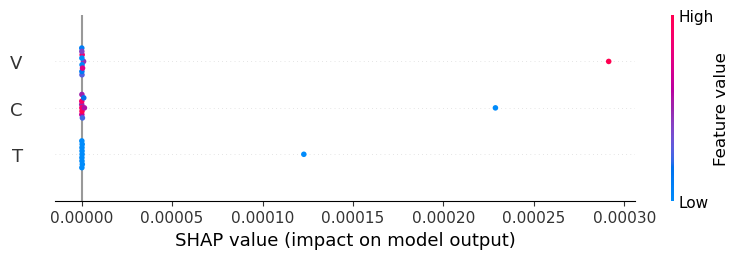

In [164]:
shap.summary_plot(importance_scores, X2[0:10][0],feature_names=["T","C","V"])

In [220]:
shap_values = explainer.shap_values(X2)

AttributeError: in user code:

    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 378, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 667, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "C:\Users\sarbaoui01\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=(62544, 10, 3), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [205]:
X2[1]

array([[3.40886440e+01, 3.87026198e-03, 3.54332119e+00],
       [3.40886440e+01, 3.87059978e-03, 3.54268885e+00],
       [3.40886440e+01, 3.87632213e-03, 3.54278608e+00],
       [3.40886440e+01, 3.87250221e-03, 3.54304387e+00],
       [3.40886440e+01, 3.87533918e-03, 3.54281571e+00],
       [3.40886440e+01, 3.87325390e-03, 3.54293046e+00],
       [3.40886440e+01, 3.87511478e-03, 3.54274830e+00],
       [3.40886440e+01, 3.87239513e-03, 3.54341106e+00],
       [3.40886440e+01, 3.86793600e-03, 3.54361282e+00],
       [3.40886440e+01, 3.87491863e-03, 3.54256067e+00]])